In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from VoCC import VortexCorrelationClustering
import pandas as pd
from py_eddy_tracker.dataset.grid import UnRegularGridDataset
from datetime import datetime

%run ../scripts/experiment_utils.py

# Automatic Data Comparison 

We want to evaluate our VoCC approach objectively against the results from the *py-eddy-tracker*.
As this method works on different data which covers the complete study area our task is to find a common set of eddies which should be detected. 

Therefore we value *py-eddy-tracker* as the truth and find those eddies of its result which are also covered by lagrangian particles which are the input to VoCC. 
Only when a certain threshold of particles is present in such eddies we add them to our ground truth set.

In [2]:
MIN_PARTICLES = 40

In [3]:
# Use the py eddy tracker
g = UnRegularGridDataset('../data/ssh_u_v_1d_20111029.nc',
                      'nav_lon', 'nav_lat', centered=True)
g.high_filter('ssh',w_cut=700,factor=8.0)
date = datetime(2011,10,29)
a,c = g.eddy_identification('ssh', 'u', 'v', date = date, step=0.004, shape_error=70)


In [4]:
# Load the particles dataset

coordinates = np.load('../data/particles_29102011.npy')
X,Y,U,V = coordinates[::3].T

# The magnitude of the movement are two days we normalize them to one.
U /= 2
V /= 2
# Set outliers to zero
U[U > 1] = 0
V[V > .5] = 0

In [5]:
def extract_lagrangian_eddies(eddy_dataset, particles_x, particles_y, particle_threshold):
    counts, _ = np.histogram(eddy_dataset.contains(particles_x, particles_y), bins = np.arange( len(eddy_dataset)+1))
    mask_indices = np.argwhere(counts >= particle_threshold).squeeze()

    mask = np.zeros(len(eddy_dataset.obs), dtype=bool)
    mask[mask_indices] = True

    return eddy_dataset.extract_with_mask(mask)

In [6]:
# Calculate the dsitribution of labels 
vocc = VortexCorrelationClustering(radii=np.arange(4,24,4),cell_size= .07, sectors = 15, circle_coverage_rate = .75, qth_threshold = .99, min_points = .01)
labels = vocc.fit(coordinates).labels_

particle_eddy_a = extract_lagrangian_eddies(a, X, Y, MIN_PARTICLES).contains(coordinates[:,0],coordinates[:, 1])
particle_eddy_c = extract_lagrangian_eddies(c, X, Y, MIN_PARTICLES).contains(coordinates[:,0],coordinates[:, 1])

particle_eddy_c[particle_eddy_c >= 0] += particle_eddy_a.max() +1

particle_eddy = np.max(np.vstack((particle_eddy_a, particle_eddy_c)), axis = 0)
dataframe = pd.DataFrame(np.vstack((labels, particle_eddy_a, particle_eddy_c, particle_eddy)).T, columns= ['vocclabel', 'particleassignment_a', 'particleassignment_c', 'particleassignment'])
cluster_result = np.zeros((dataframe['vocclabel'].unique().shape[0],dataframe['particleassignment'].unique().shape[0]))

for f in dataframe.groupby(['vocclabel', 'particleassignment'])['vocclabel'].count().items():
    cluster_result[np.argwhere(dataframe['vocclabel'].unique() == f[0][0]).squeeze(), np.argwhere(dataframe['particleassignment'].unique() == f[0][1]).squeeze()] = f[1]

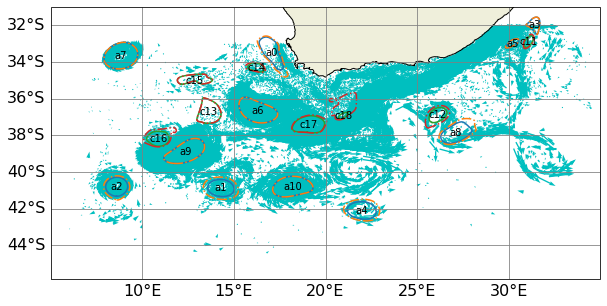

In [7]:
# We plot the py-eddy-tracker eddies on to of a quiver plot with the available particles to show what would be possible to detect with the available data.
lat_min = -45
lat_max = -31
lon_min = 5
lon_max = 35

extent = [lon_min, lon_max, lat_min, lat_max]
projection = ccrs.PlateCarree()
fig , ax = plt.subplots(1,1,figsize=(10,5),subplot_kw=dict(projection=projection))

ax.quiver(X,Y,U,V,scale=20,color='c',transform=ccrs.PlateCarree())
extract_lagrangian_eddies(a, X, Y, MIN_PARTICLES).display(ax, transform = ccrs.PlateCarree())
extract_lagrangian_eddies(c, X, Y, MIN_PARTICLES).display(ax,transform=ccrs.PlateCarree())

ax.set_extent(extent)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
gl = ax.gridlines(draw_labels=True,color='grey')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style, gl.ylabel_style = {'fontsize': 16}, {'fontsize': 16}

# title = ax.set_title(f'Min Particles {MIN_PARTICLES}', fontsize = 22)


for i, o in enumerate(extract_lagrangian_eddies(a, X, Y, MIN_PARTICLES).obs):
    ax.text(o['lon'], o['lat'], f'a{i}', va='center', ha='center')
for i, o in enumerate(extract_lagrangian_eddies(c, X, Y, MIN_PARTICLES).obs):
    ax.text(o['lon'], o['lat'], f'c{i + len(extract_lagrangian_eddies(a, X, Y, MIN_PARTICLES))}', va='center', ha='center')

# plt.savefig(f'../fig/py-eddy-tracker-{MIN_PARTICLES}particles.png')


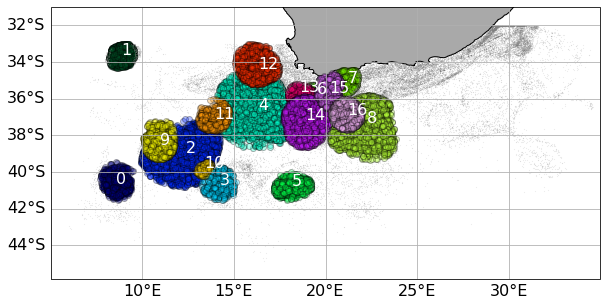

In [8]:
create_real_world_image(coordinates, labels, 'VoCC-result-real-world', True)

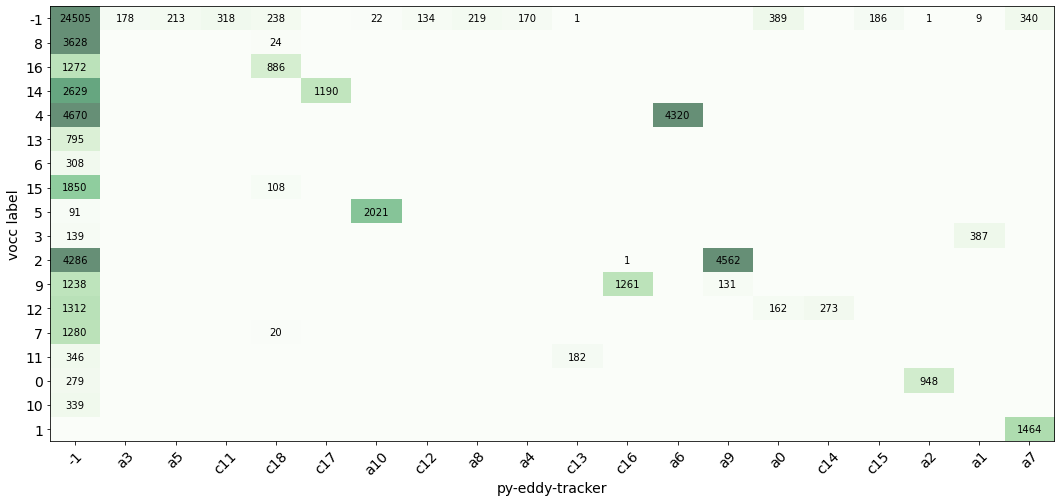

In [9]:
# Plotting the distribution of labels across the detected eddies by py eddy tracker.
fig = plt.figure(figsize = (18,8))
ax = fig.add_subplot(1,1,1)
#/ cluster_result.sum(axis = 0).reshape(1, -1)
ax.imshow(cluster_result , cmap = 'Greens', aspect='auto', alpha = .6, vmax = 3000)

def num_to_str(num, n_a):
    if num < 0:
        return str(int(num))
    if num < n_a:
        return f'a{num:.0f}'
    return f'c{num:.0f}'

ticks = ['-1'] + [f'a{d:.0f}' for d in dataframe['particleassignment_a'].unique() if d >= 0] + [f'c{d:.0f}' for d in dataframe['particleassignment_c'].unique() if d >= 0]
ticks = [num_to_str(d, len(extract_lagrangian_eddies(a, X, Y, MIN_PARTICLES))) for d in dataframe['particleassignment'].unique()]
xticks = ax.set_xticks(range(cluster_result.shape[1]), ticks, fontsize=14, rotation=45)
yticks = ax.set_yticks(range(dataframe['vocclabel'].unique().shape[0]), dataframe['vocclabel'].unique().astype(int), fontsize=14)
xlabel = ax.set_xlabel('py-eddy-tracker', fontsize=14)
ylabel = ax.set_ylabel('vocc label', fontsize=14)

for i in range(cluster_result.shape[1]):
   for j in range(dataframe['vocclabel'].unique().shape[0]):
      value= cluster_result[j, i]
      if value == 0:
         continue
      ax.text(i, j, str(int(value)), va='center', ha='center')

In [21]:
from sklearn.metrics import rand_score, adjusted_rand_score, precision_score, recall_score, adjusted_mutual_info_score


label_mask = particle_eddy > -1


print('All labels from VoCC and py-eddy-tracker')
print(f'\tRAND Score: {rand_score(particle_eddy, labels):.3f}, Asjusted RAND Score: {adjusted_rand_score(particle_eddy, labels):.3f}')
print('Only labels that match a PET Eddy')
print(f'\tRAND Score: {rand_score(particle_eddy[label_mask], labels[label_mask]):.3f}, Asjusted RAND Score: {adjusted_rand_score(particle_eddy[label_mask], labels[label_mask]):.3f}')



print()


print(f'Precision to identify an eddy: {precision_score(np.where(particle_eddy < 0, particle_eddy, 0), np.where(labels < 0, labels, 0), pos_label= -1):.3f}')
print(f'Recall to identify an eddy: {recall_score(np.where(particle_eddy < 0, particle_eddy, 0), np.where(labels < 0, labels, 0), pos_label= -1):.3f}')

All labels from VoCC and py-eddy-tracker
	RAND Score: 0.595, Asjusted RAND Score: 0.199
Only labels that match a PET Eddy
	RAND Score: 0.979, Asjusted RAND Score: 0.908

Precision to identify an eddy: 0.910
Recall to identify an eddy: 0.500


In [27]:
from pathlib import Path
import pickle as pckl

labels_file = Path('../data/intermediate/label.p')


if labels_file.is_file():
    saved_labels = None
    with labels_file.open('rb') as file:
        saved_labels = pckl.load(file)

    for k in saved_labels.keys():
        s = saved_labels[k]['stride']
        arand = adjusted_rand_score(particle_eddy[::s], saved_labels[k]['label'])
        arand_wo_noise = adjusted_rand_score(particle_eddy[::s][label_mask[::s]], saved_labels[k]['label'][label_mask[::s]])

        print(f'{k:14s} - {arand:.3f} aRAND - {arand_wo_noise:.3f} aRAND wo noise')





dbscan_10km    - 0.334 aRAND - 0.503 aRAND wo noise
dbscan_14km    - 0.128 aRAND - 0.794 aRAND wo noise
dbscan_20km    - 0.208 aRAND - 0.573 aRAND wo noise
optics         - 0.075 aRAND - 0.054 aRAND wo noise
stdbscan       - 0.112 aRAND - 0.624 aRAND wo noise
vocc           - 0.222 aRAND - 0.946 aRAND wo noise
